<a href="https://colab.research.google.com/github/open-mmlab/mmsegmentation/blob/main/demo/MMSegmentation_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Finetune a semantic segmentation model on a new dataset

To finetune on a customized dataset, the following steps are necessary. 
1. Add a new dataset class. 
2. Create a config file accordingly. 
3. Perform training and evaluation. 

We need to convert the annotation into semantic map format as an image.

In [5]:
import torch, mmseg, mmcv, mmengine, os, shutil, numpy as np
from tqdm import tqdm
from PIL import Image
from matplotlib import pyplot as plt

In [6]:
# define dataset root and directory for images and annotations
data_root = 'Dataset'
img_dir = 'Images'
ann_dir = 'Labels'

# Color code of the annotation images
#                              R-G-B
# ---------------------------------------------------------
# Outside billboards

#     0.                    000-000-000  (black)

# ---------------------------------------------------------
# Inside billboards

#     1. Billboard          255-255-255  (white)

#     2. Field player       255-000-000  (red)
#     3. Goalkeeper         000-255-000  (green)
#     4. Referee            000-000-255  (blue)
#     5. Assistant referee  255-255-000  (yellow)
#     6. Other human        255-000-255  (pink)

#     7. Ball               000-255-255  (turquoise)

#     8. Goal post          128-000-000  (dark red)
#     9. Goal net           000-128-000  (dark green)
#    10. Net post           000-000-128  (dark blue)
#    11. Cross-bar          064-064-064  (dark gray)

#    12. Corner flag        128-128-000  (dark yellow)
#    13. Assistant flag     128-000-128  (purple)

#    14. Microphone         000-128-128  (dark turquoise)
#    15. Camera             255-128-000  (orange)
   
#    16. Other object       192-192-192  (light gray)
  
#    17. Don't care         128-128-128  (gray)
# ---------------------------------------------------------

# Define the classes and the palette for the segmentation of my dataset
old_classes = ['Outside billboards', 'Billboard', 'Field player', 'Goalkeeper', 'Referee', 'Assistant referee', 'Other human', 'Ball', 'Goal post', 'Goal net', 'Net post', 'Cross-bar', 'Corner flag', 'Assistant flag', 'Microphone', 'Camera', 'Other object', 'Don\'t care']
old_palette = [[0, 0, 0], [255, 255, 255], [255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0], [255, 0, 255], [0, 255, 255], [128, 0, 0], [0, 128, 0], [0, 0, 128], [64, 64, 64], [128, 128, 0], [128, 0, 128], [0, 128, 128], [255, 128, 0], [192, 192, 192], [128, 128, 128]]
old_palette_dict = {tuple(p): i for i, p in enumerate(old_palette)}
old_classes_dict = {i: c for i, c in enumerate(old_classes)}

new_classes = ['Outside billboards', 'Billboard', 'Goal net']
# new_classes = old_classes
# new_classes = ['Outside billboards', 'Goal net']

new_palette = [old_palette[old_classes.index(c)] for c in new_classes]
new_palette_dict = {tuple(p): i for i, p in enumerate(new_palette)}
new_classes_dict = {i: c for i, c in enumerate(new_classes)}

In [7]:
conversion_old_to_new = np.zeros(len(old_classes), dtype=np.uint8)  # By default, all classes are mapped to 0 (Outside billboards)
# conversion_old_to_new = np.array([2 for i in range(len(old_classes))], dtype=np.uint8)  # By default, all classes are mapped to 2 (Other object)
conversion_old_to_new[old_classes.index('Billboard')] = new_classes.index('Billboard')
conversion_old_to_new[old_classes.index('Goal net')] = new_classes.index('Goal net')

# conversion_old_to_new = np.array([i for i in range(len(old_classes))], dtype=np.uint8)  # No conversion

# conversion_old_to_new[old_classes.index('Goal net')] = 1  # Goal net
print(conversion_old_to_new)

[0 1 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]


In [8]:
old_classes_dict

{0: 'Outside billboards',
 1: 'Billboard',
 2: 'Field player',
 3: 'Goalkeeper',
 4: 'Referee',
 5: 'Assistant referee',
 6: 'Other human',
 7: 'Ball',
 8: 'Goal post',
 9: 'Goal net',
 10: 'Net post',
 11: 'Cross-bar',
 12: 'Corner flag',
 13: 'Assistant flag',
 14: 'Microphone',
 15: 'Camera',
 16: 'Other object',
 17: "Don't care"}

In [9]:
old_palette_dict

{(0, 0, 0): 0,
 (255, 255, 255): 1,
 (255, 0, 0): 2,
 (0, 255, 0): 3,
 (0, 0, 255): 4,
 (255, 255, 0): 5,
 (255, 0, 255): 6,
 (0, 255, 255): 7,
 (128, 0, 0): 8,
 (0, 128, 0): 9,
 (0, 0, 128): 10,
 (64, 64, 64): 11,
 (128, 128, 0): 12,
 (128, 0, 128): 13,
 (0, 128, 128): 14,
 (255, 128, 0): 15,
 (192, 192, 192): 16,
 (128, 128, 128): 17}

In [10]:
new_classes_dict

{0: 'Outside billboards', 1: 'Billboard', 2: 'Goal net'}

In [11]:
new_palette_dict

{(0, 0, 0): 0, (255, 255, 255): 1, (0, 128, 0): 2}

In [12]:
ann_source_dir = 'Labels_source'

(1920, 1080)
(1080, 1920)


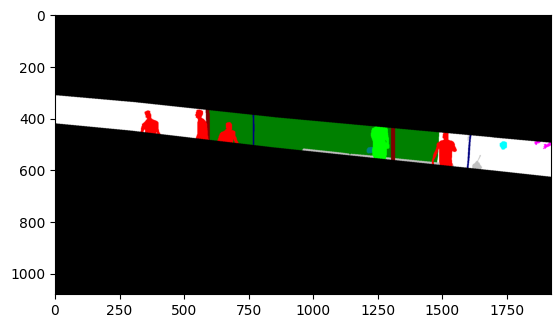

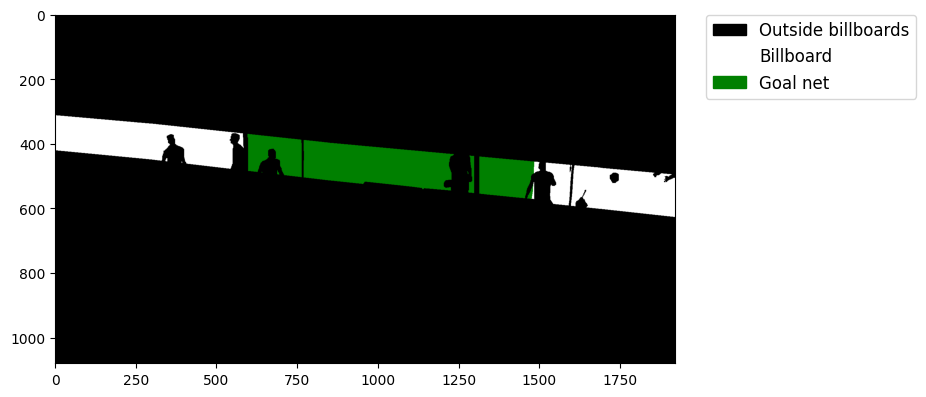

In [13]:
# Convert the annotations to the new classes
import matplotlib.patches as mpatches

ann_source_dir = 'Labels_source'

ann_path = os.path.join(data_root, ann_source_dir, 'Stadium_6_Match_1_in_1fps_6275.png')
img = Image.open(ann_path)
plt.imshow(np.array(img.convert('RGB')))

print(img.size)
img_np = np.array(img, dtype=np.uint8)
print(img_np.shape)
# For each pixel x, replace it by the value conversion_old_to_new[x]
img_np = conversion_old_to_new[img_np]
img = Image.fromarray(img_np).convert('P')
img.putpalette(np.array(new_palette, dtype=np.uint8))

plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

patches = [mpatches.Patch(color=np.array(new_palette[i])/255., label=new_classes[i]) for i in range(len(new_classes))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='large')


plt.show()

In [ ]:
all_ann_files = os.listdir(os.path.join(data_root, ann_source_dir))

def convert_ann_file(files):
    for file in tqdm(files):
        # Open the image
        ann = Image.open(os.path.join(data_root, ann_source_dir, file))
        # Create a numpy array from the image
        ann_np = np.array(ann, dtype=np.uint8)
        # For each pixel x, replace it by the value conversion_old_to_new[x]
        ann_np = conversion_old_to_new[ann_np]
        # Create the image from the numpy array
        seg_img = Image.fromarray(ann_np).convert('P')
        # Add the new palette to the image
        seg_img.putpalette(np.array(new_palette, dtype=np.uint8))
        # Save the image
        seg_img.save(os.path.join(data_root, ann_dir, file))

from multiprocessing import Pool

# Define the number of processes
num_processes = 16

# Create a pool of processes
pool = Pool(processes=num_processes)

# Split the list of files into 8 chunks
files_chunks = np.array_split(all_ann_files, num_processes)

# Apply the function convert_ann_file to each chunk
pool.map(convert_ann_file, files_chunks)

# Close the pool
pool.close()

# Merge the chunks
pool.join()

After processing the data, we need to implement `load_annotations` function in the new dataset class `StanfordBackgroundDataset`.

In [3]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset


# Check if the dataset SoccerNet is already registered
if 'SoccerNet' not in DATASETS:
	@DATASETS.register_module()
	class SoccerNet(BaseSegDataset):
		METAINFO = dict(classes = new_classes, palette = new_palette)
		def __init__(self, **kwargs):
			super().__init__(img_suffix='.png', seg_map_suffix='.png', **kwargs)
    

### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [3]:
from mmengine import Config
cfg = Config.fromfile('pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py')
# print(f'Config:\n{cfg.pretty_text}')

Since the given config is used to train PSPNet on the cityscapes dataset, we need to modify it accordingly for our new dataset.  

In [4]:
# # Since we use only one GPU, BN is used instead of SyncBN
# cfg.norm_cfg = dict(type='BN', requires_grad=True)
# cfg.crop_size = (256, 256)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = len(new_classes)
cfg.model.auxiliary_head.num_classes = len(new_classes)

# Modify dataset type and path
cfg.dataset_type = 'SoccerNet'
cfg.data_root = data_root

cfg.train_dataloader.batch_size = 2

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    # dict(type='RandomResize', scale=(320, 240), ratio_range=(0.5, 2.0), keep_ratio=True),
    # dict(type='Resize', scale=(320, 240), keep_ratio=True),
    # dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    # dict(type='Resize', scale=(320, 240), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]


cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = 'splits/val.txt'

cfg.test_dataloader = cfg.val_dataloader


# Load the pretrained weights
# cfg.load_from = 'pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.train_cfg.max_iters = 2000
cfg.train_cfg.val_interval = 200
cfg.default_hooks.logger.interval = 10
cfg.default_hooks.checkpoint.interval = 200

# Set seed to facilitate reproducing the result
cfg['randomness'] = dict(seed=0)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
crop_size = (
    512,
    1024,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        1024,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    type='SegDataPreProcessor')
data_root = 'Dataset'
dataset_type = 'SoccerNet'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=200, type='CheckpointHook'),
    logger=dict(interval=10, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
img_ratios = [
    0.5,
    0.75,
    1.0,
    1.25,
    1.5,
    1.75,
]
load_from = 

### Train and Evaluation

In [ ]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

In [ ]:
# start training
runner.train()

Inference with trained model

Loads checkpoint by local backend from path: work_dir/mask2former_swin-t_1xb2-90k_soccernet/best_mIoU_iter_1800.pth


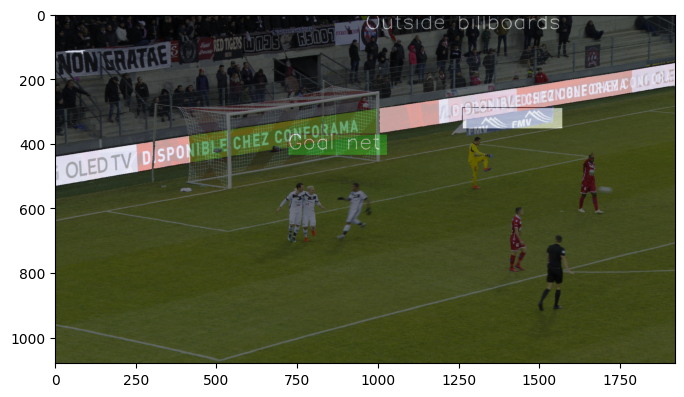

In [9]:
from mmseg.apis import init_model, inference_model, show_result_pyplot
import matplotlib.pyplot as plt
import os

from mmengine import Config
cfg = Config.fromfile('mask2former_swin-t_1xb2-90k_soccernet.py')

# Init the model from the config and the checkpoint
checkpoint_path = 'work_dir/mask2former_swin-t_1xb2-90k_soccernet/best_mIoU_iter_1800.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

# img = mmcv.imread(os.path.join(data_root, img_dir, 'Stadium_1_Match_1_in_1fps_0491.png'))
# img = mmcv.imread(os.path.join(data_root, img_dir, 'Stadium_4_Match_1_in_1fps_0494.png'))
# img = mmcv.imread(os.path.join(data_root, img_dir, 'Stadium_4_Match_1_in_1fps_0270.png'))
img = mmcv.imread(os.path.join(data_root, img_dir, 'Stadium_1_Match_1_in_1fps_0888.png'))
result = inference_model(model, img)
# Show the result without using show_result_pyplot
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result)
plt.imshow(mmcv.bgr2rgb(vis_result))
# Save the result image
plt.savefig('result.png', dpi=1000)